In [1]:
#module imports
import pandas as pd, numpy as np
from textblob import TextBlob
from langdetect import detect

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata

In [27]:
#import all dataframes
az_reviews = pd.read_excel('../data/Amazon_reviews_with_scores.xlsx')
az_reviews = az_reviews.drop(['ReviewID'],axis=1)

tg_reviews = pd.read_csv('../data/target_reviews_clean.csv')
tg_reviews['verified_purchaser'] = tg_reviews['verified_purchaser'].astype(bool)
tg_reviews.rename({'verified_purchaser':'verified_purchase'},inplace=True,axis=1)

bb_reviews = pd.read_excel('../data/BB_Review_data.xlsx')
bb_reviews = bb_reviews.drop(['ReviewID'],axis=1)


In [28]:
#combine all dataframes
all_reviews = pd.concat(
    [
        az_reviews,
        tg_reviews,
        bb_reviews
    ]
)
all_reviews = all_reviews.reset_index()

In [29]:
#remove the duplicate / error indices
all_reviews = all_reviews.drop(['index'],axis=1)
#add the specific site from which the data came
all_reviews['site'] = np.select(
    [
        all_reviews['prodSiteID'].str.contains('BB'),
        all_reviews['prodSiteID'].str.contains('target'),
        all_reviews['prodSiteID'].str.contains('Amazon')
    ],
    [
        'BestBuy',
        'Target',
        'Amazon'
    ]
)


In [30]:
#helper functions
def get_lang(data):
    lang = None
    try:
        lang = detect(
            ''.join(
                w.lower() if w.isalpha() else " " for w in data
            )
        )
    except:
        lang = 'Unk'
    return lang

def get_sentiments(data):
    res = textblob.TextBlob(
        data
    )
    return [res.subjectivity,res.polarity]

In [31]:
all_reviews

,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site
0,1,Amazon1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.604943,0.273504,282.0,NaN,NaN,Amazon
1,1,Amazon1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.513636,0.484091,138.0,NaN,NaN,Amazon
2,1,Amazon1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.570455,0.333636,373.0,NaN,NaN,Amazon
3,1,Amazon1,Awesome,David Chaves Rojas,"Got my phone, 10/10. No scratches, still have ...",5,0,True,0.000000,0.000000,83.0,NaN,NaN,Amazon
4,1,Amazon1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.727273,0.568182,170.0,NaN,NaN,Amazon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46074,3,BB3,Returned this product,TraceyPortchester,did not have the capacity to safeguard all of ...,1,0,True,NaN,NaN,NaN,NaN,NaN,BestBuy
46075,3,BB3,forget BB,Deede,Received in email but not downloadable. Geek ...,1,0,True,NaN,NaN,NaN,NaN,NaN,BestBuy
46076,3,BB3,Decent product,RamonI,It’s a good antivirus program it does keep my ...,4,0,True,NaN,NaN,NaN,NaN,NaN,BestBuy
46077,3,BB3,Works great,GracieW,"Works great, never had a problem with it, will...",5,0,True,NaN,NaN,NaN,NaN,NaN,BestBuy


In [32]:
#add the predicted language, poliarity, subjectivity
all_reviews['review_lang'] = all_reviews.apply(
    lambda row: get_lang(str(row['review_content'])), axis = 1
)

In [33]:
# all_reviews[['review_subjectivity','review_polarity']] = all_reviews.apply(
#     lambda row: get_sentiments(str(row['review_header'])+ ' '+ str(row['review_content'])),axis=1
# )
all_reviews['review_subjectivity'] = all_reviews.apply(
    lambda row: TextBlob(
        str(row['review_header'])+ ' '+ str(row['review_content'])
    ).subjectivity,axis=1
)

all_reviews['review_polarity'] = all_reviews.apply(
    lambda row: TextBlob(
        str(row['review_header'])+ ' '+ str(row['review_content'])
    ).polarity,axis=1
)

In [34]:
all_reviews['review_length'] = (all_reviews['review_content'].str.split(' ').str.len()) #get length in words

In [35]:
#review metrics by site, all reviews (including bad ones)
def add_metr_cols(df):
    df['IQR'] = df['75%'] - df['25%']
    df['UpperLimit'] = df['75%'] + (1.5 * df['IQR'])
    df['LowerLimit'] = df['25%'] - (1.5 * df['IQR'])
    return df

all_review_metrics_target = add_metr_cols(
    pd.DataFrame(all_reviews[all_reviews['site']=='Target'].describe().T.reset_index())
)

all_review_metrics_amazon = add_metr_cols(
    pd.DataFrame(all_reviews[all_reviews['site']=='Amazon'].describe().T.reset_index())
)

all_review_metrics_bestbuy = add_metr_cols(pd.DataFrame(all_reviews[all_reviews['site']=='BestBuy'].describe().T.reset_index()))

all_review_metrics_target_en = add_metr_cols(
    pd.DataFrame(all_reviews[(all_reviews['site']=='Target')&(all_reviews['review_lang']=='en')].describe().T.reset_index())
)

all_review_metrics_amazon_en = add_metr_cols(
    pd.DataFrame(all_reviews[(all_reviews['site']=='Amazon')&(all_reviews['review_lang']=='en')].describe().T.reset_index())
)

all_review_metrics_bestbuy_en = add_metr_cols(
    pd.DataFrame(all_reviews[(all_reviews['site']=='BestBuy')&(all_reviews['review_lang']=='en')].describe().T.reset_index())
)

#review metrics, all sites, all reviews
all_review_metrics = add_metr_cols(all_reviews.describe().T.reset_index())

all_review_metrics_en = add_metr_cols(all_reviews[all_reviews['review_lang']=='en'].describe().T.reset_index())

#star rating, subjectivity, polarity, ...
target_cols = ['review_star_rating', 'review_subjectivity', 'review_polarity', 'review_length']

all_reviews[['site_outlier','site_outlier_en','global_outlier','global_outlier_en']] = 0,0,0,0

selection_all = {
    'Amazon':all_review_metrics_amazon,
    'BestBuy':all_review_metrics_bestbuy,
    'Target':all_review_metrics_target
}

selection_en = {
    'Amazon':all_review_metrics_amazon_en,
    'BestBuy':all_review_metrics_bestbuy_en,
    'Target':all_review_metrics_target_en
}

for i, row in all_reviews.iterrows():
    site_out = selection_all[row['site']]
    site_out_en = selection_en[row['site']]
    for col in target_cols:
        #determine if the value is an outlier, globally
        all_reviews.loc[i,'global_outlier'] += int(
            all_review_metrics[all_review_metrics['index']==col].iloc[0]['UpperLimit'] < row[col] or
            all_review_metrics[all_review_metrics['index']==col].iloc[0]['LowerLimit'] > row[col]
        )
        #determine if the value is an outlier for english-only / well spelled reviews
        all_reviews.loc[i,'global_outlier_en'] += int(
            all_review_metrics_en[all_review_metrics_en['index']==col].iloc[0]['UpperLimit'] < row[col] or
            all_review_metrics_en[all_review_metrics_en['index']==col].iloc[0]['LowerLimit'] > row[col]
        )
        #determine if the value is an outlier amongst all values for this site.
        all_reviews.loc[i,'site_outlier'] += int( 
           site_out[site_out['index']==col].iloc[0]['UpperLimit'] < row[col] or 
           site_out[site_out['index']==col].iloc[0]['LowerLimit'] > row[col] 
        )
        #determine if the value is an outlier amongst all values associated to english-only / well-spelled reviews for this site
        all_reviews.loc[i,'site_outlier_en'] += int(
           site_out_en[site_out_en['index']==col].iloc[0]['UpperLimit'] < row[col] or 
           site_out_en[site_out_en['index']==col].iloc[0]['LowerLimit'] > row[col] 
        )


#each of the outlier columns will have a number greater than 0 if the 
#record has an outlier in one or more specified columns under the given context.
#e.g. site_outlier_en means that for a row containing "Target" as the site - 
    # the record has n values that are outliers where n is the number of columns.
    #not keeping track of where there are outliers, presently.
    # just knowing the record has outliers...probably could be something to determine to include or exclude.
        
    #more than likely, we'll need to go with review_lang == 'en' and may need to filter down on site outliers
        


In [ ]:
all_review_metrics_amazon['type'] = 'site_amazon'
all_review_metrics_bestbuy['type'] = 'site_bestbuy'
all_review_metrics_target['type'] = 'site_target'
all_review_metrics_amazon_en['type'] = 'site_amazon_english'
all_review_metrics_bestbuy_en['type'] = 'site_bestbuy_english'
all_review_metrics_target_en['type'] = 'site_target_english'
all_review_metrics['type'] = 'global'
all_review_metrics_en['type'] = 'global_en'

review_metrics = pd.concat([
    all_review_metrics,all_review_metrics_amazon,
    all_review_metrics_bestbuy,all_review_metrics_target,
    all_review_metrics_en,all_review_metrics_amazon_en,
    all_review_metrics_bestbuy_en,all_review_metrics_target_en
])

review_metrics.to_csv('../data/combined_review_metrics.csv')

all_reviews.to_csv('../data/combined_review_table.csv')


In [ ]:
display(
    all_reviews[all_reviews['global_outlier']>0],
    all_reviews[all_reviews['global_outlier_en']>0],
    all_reviews[all_reviews['site_outlier']>0],
    all_reviews[all_reviews['site_outlier_en']>0]
)

,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en
11,1,Amazon1,Excelente,"Moldea muy bien, me gustó mucho! Es cómodo de ...","En perfectas condiciones, 100% el estado de la...",5,1,True,0.000000,0.000000,11.0,NaN,es,Amazon,1,1,1,1
13,1,Amazon1,Excelente,Diego Sanchez,Todo estuvo muy bien,5,0,True,0.000000,0.000000,4.0,NaN,es,Amazon,1,1,1,1
17,1,Amazon1,App loading,Amazon Customer,"I am still in the process of loading app,s in ...",5,0,True,0.000000,0.000000,22.0,NaN,en,Amazon,1,1,1,1
19,1,Amazon1,Practically brand new,Gustavo Perez,From the description of the listing I was expe...,5,0,True,0.386518,0.036024,158.0,NaN,en,Amazon,0,0,1,1
21,1,Amazon1,Definitely worth the investment,Richard Dumostil,I was reluctant to buy a refurbished phone but...,5,9,True,0.593506,0.333766,90.0,NaN,en,Amazon,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46071,3,BB3,Accident,Aenavarro,Never downloaded- purchase was accident\nI alr...,1,0,True,0.000000,0.000000,8.0,NaN,en,BestBuy,2,2,2,2
46072,3,BB3,couldn’t even get the item.,tony,i tried to download and it just threw me an er...,1,1,True,0.300000,1.000000,16.0,NaN,en,BestBuy,1,1,1,1
46073,3,BB3,"Unable to download!!! Message comes up ""Bad R...",TEEE,"Unable to download!!! Message comes up ""Bad R...",1,1,True,0.583333,-0.882031,9.0,NaN,en,BestBuy,2,2,2,2
46074,3,BB3,Returned this product,TraceyPortchester,did not have the capacity to safeguard all of ...,1,0,True,0.000000,0.000000,11.0,NaN,en,BestBuy,2,2,2,2


,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en
11,1,Amazon1,Excelente,"Moldea muy bien, me gustó mucho! Es cómodo de ...","En perfectas condiciones, 100% el estado de la...",5,1,True,0.000000,0.000000,11.0,NaN,es,Amazon,1,1,1,1
13,1,Amazon1,Excelente,Diego Sanchez,Todo estuvo muy bien,5,0,True,0.000000,0.000000,4.0,NaN,es,Amazon,1,1,1,1
17,1,Amazon1,App loading,Amazon Customer,"I am still in the process of loading app,s in ...",5,0,True,0.000000,0.000000,22.0,NaN,en,Amazon,1,1,1,1
19,1,Amazon1,Practically brand new,Gustavo Perez,From the description of the listing I was expe...,5,0,True,0.386518,0.036024,158.0,NaN,en,Amazon,0,0,1,1
21,1,Amazon1,Definitely worth the investment,Richard Dumostil,I was reluctant to buy a refurbished phone but...,5,9,True,0.593506,0.333766,90.0,NaN,en,Amazon,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46071,3,BB3,Accident,Aenavarro,Never downloaded- purchase was accident\nI alr...,1,0,True,0.000000,0.000000,8.0,NaN,en,BestBuy,2,2,2,2
46072,3,BB3,couldn’t even get the item.,tony,i tried to download and it just threw me an er...,1,1,True,0.300000,1.000000,16.0,NaN,en,BestBuy,1,1,1,1
46073,3,BB3,"Unable to download!!! Message comes up ""Bad R...",TEEE,"Unable to download!!! Message comes up ""Bad R...",1,1,True,0.583333,-0.882031,9.0,NaN,en,BestBuy,2,2,2,2
46074,3,BB3,Returned this product,TraceyPortchester,did not have the capacity to safeguard all of ...,1,0,True,0.000000,0.000000,11.0,NaN,en,BestBuy,2,2,2,2


,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en
3,1,Amazon1,Awesome,David Chaves Rojas,"Got my phone, 10/10. No scratches, still have ...",5,0,True,1.000000,1.000000,14.0,NaN,en,Amazon,2,2,0,0
11,1,Amazon1,Excelente,"Moldea muy bien, me gustó mucho! Es cómodo de ...","En perfectas condiciones, 100% el estado de la...",5,1,True,0.000000,0.000000,11.0,NaN,es,Amazon,1,1,1,1
13,1,Amazon1,Excelente,Diego Sanchez,Todo estuvo muy bien,5,0,True,0.000000,0.000000,4.0,NaN,es,Amazon,1,1,1,1
17,1,Amazon1,App loading,Amazon Customer,"I am still in the process of loading app,s in ...",5,0,True,0.000000,0.000000,22.0,NaN,en,Amazon,1,1,1,1
22,1,Amazon1,Funciona y se mira bien,Daniel831,Llevo un día usándolo y aparecer funciona bien...,5,0,True,0.000000,0.000000,24.0,NaN,es,Amazon,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46072,3,BB3,couldn’t even get the item.,tony,i tried to download and it just threw me an er...,1,1,True,0.300000,1.000000,16.0,NaN,en,BestBuy,1,1,1,1
46073,3,BB3,"Unable to download!!! Message comes up ""Bad R...",TEEE,"Unable to download!!! Message comes up ""Bad R...",1,1,True,0.583333,-0.882031,9.0,NaN,en,BestBuy,2,2,2,2
46074,3,BB3,Returned this product,TraceyPortchester,did not have the capacity to safeguard all of ...,1,0,True,0.000000,0.000000,11.0,NaN,en,BestBuy,2,2,2,2
46075,3,BB3,forget BB,Deede,Received in email but not downloadable. Geek ...,1,0,True,0.000000,0.000000,15.0,NaN,en,BestBuy,2,2,2,2


,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en
3,1,Amazon1,Awesome,David Chaves Rojas,"Got my phone, 10/10. No scratches, still have ...",5,0,True,1.000000,1.000000,14.0,NaN,en,Amazon,2,2,0,0
11,1,Amazon1,Excelente,"Moldea muy bien, me gustó mucho! Es cómodo de ...","En perfectas condiciones, 100% el estado de la...",5,1,True,0.000000,0.000000,11.0,NaN,es,Amazon,1,1,1,1
13,1,Amazon1,Excelente,Diego Sanchez,Todo estuvo muy bien,5,0,True,0.000000,0.000000,4.0,NaN,es,Amazon,1,1,1,1
17,1,Amazon1,App loading,Amazon Customer,"I am still in the process of loading app,s in ...",5,0,True,0.000000,0.000000,22.0,NaN,en,Amazon,1,1,1,1
22,1,Amazon1,Funciona y se mira bien,Daniel831,Llevo un día usándolo y aparecer funciona bien...,5,0,True,0.000000,0.000000,24.0,NaN,es,Amazon,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46072,3,BB3,couldn’t even get the item.,tony,i tried to download and it just threw me an er...,1,1,True,0.300000,1.000000,16.0,NaN,en,BestBuy,1,1,1,1
46073,3,BB3,"Unable to download!!! Message comes up ""Bad R...",TEEE,"Unable to download!!! Message comes up ""Bad R...",1,1,True,0.583333,-0.882031,9.0,NaN,en,BestBuy,2,2,2,2
46074,3,BB3,Returned this product,TraceyPortchester,did not have the capacity to safeguard all of ...,1,0,True,0.000000,0.000000,11.0,NaN,en,BestBuy,2,2,2,2
46075,3,BB3,forget BB,Deede,Received in email but not downloadable. Geek ...,1,0,True,0.000000,0.000000,15.0,NaN,en,BestBuy,2,2,2,2


In [ ]:
all_reviews

,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en
0,1,Amazon1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.588232,0.258266,49.0,NaN,en,Amazon,0,0,0,0
1,1,Amazon1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.430909,0.447273,24.0,NaN,en,Amazon,0,0,0,0
2,1,Amazon1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.554959,0.394215,66.0,NaN,en,Amazon,0,0,0,0
3,1,Amazon1,Awesome,David Chaves Rojas,"Got my phone, 10/10. No scratches, still have ...",5,0,True,1.000000,1.000000,14.0,NaN,en,Amazon,2,2,0,0
4,1,Amazon1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.636364,0.424242,31.0,NaN,en,Amazon,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46074,3,BB3,Returned this product,TraceyPortchester,did not have the capacity to safeguard all of ...,1,0,True,0.000000,0.000000,11.0,NaN,en,BestBuy,2,2,2,2
46075,3,BB3,forget BB,Deede,Received in email but not downloadable. Geek ...,1,0,True,0.000000,0.000000,15.0,NaN,en,BestBuy,2,2,2,2
46076,3,BB3,Decent product,RamonI,Its a good antivirus program it does keep my c...,4,0,True,0.608333,0.088333,35.0,NaN,en,BestBuy,1,1,0,0
46077,3,BB3,Works great,GracieW,"Works great, never had a problem with it, will...",5,0,True,0.750000,0.800000,11.0,NaN,en,BestBuy,0,0,0,0


In [ ]:
target_products = pd.read_csv('../data/target_products_master.csv')
bb_products = pd.read_excel('../data/BB_Product_data.xlsx')
az_products = pd.read_excel('../data/Amazon_Product_data_all.xlsx')

target_products['site']='Target'
target_products.rename({'url':'URL','total_star_votes':'total_reviews'},axis=1,inplace=True)
target_products = target_products.drop(target_products.columns[0],axis=1)

# display(
#     target_products.head(),
#     bb_products.head(),
#     az_products.head()
# )

all_products = pd.concat(
    [
        target_products,
        bb_products,
        az_products
    ]
)

all_products['prod_subjectivity'] = all_products.apply(
    lambda row: TextBlob(str(row['product_details'])+' ' + str(row['product_specs'])).subjectivity,axis=1
)

all_products = all_products.reset_index().drop(['index'],axis=1)

# all_products.loc[0,'URL']


all_products['total_star_rating'] = np.select(
    [all_products['total_star_rating'].isna(),~all_products['total_star_rating'].isna()],
    [0,all_products['total_star_rating']]
)

all_products['total_reviews'] = np.select(
    [all_products['total_reviews'].isna(),~all_products['total_reviews'].isna()],
    [0,all_products['total_reviews']]
)

display(all_products)

all_products.to_csv('../data/master_product_list.csv')

,URL,product_title,product_details,product_specs,product_price,total_star_rating,total_reviews,prod_subjectivity,productID,prodSiteID,site
0,https://www.target.com/p/apple-iphone-14/-/A-8...,Apple iPhone 14,Highlights\r\n6.1-inch Super Retina XDR displa...,Dimensions (Overall): 5.78 Inches (H) x 2.82 I...,0.00,4.4,476,0.413448,1,target1,Target
1,https://www.target.com/p/samsung-galaxy-s22-ul...,Samsung Galaxy S22 Ultra 5G Unlocked (128GB) S...,Highlights\r\n8K video - the highest resolutio...,Dimensions (Overall): 6.43 Inches (H) x 3.06 I...,1199.99,4.6,8016,0.469506,2,target2,Target
2,https://www.target.com/p/hp-deskjet-2755e-wire...,HP DeskJet 2755e Wireless All-In-One Color Pri...,Highlights\r\nBest for home printing\r\nAll-in...,Dimensions (Overall): 6.06 Inches (H) x 16.7 I...,49.99,3.8,1648,0.531992,3,target3,Target
3,https://www.target.com/p/jbl-charge-5-portable...,JBL Charge 5 Portable Bluetooth Waterproof Spe...,Highlights\r\nTarget Certified Refurbished spe...,Dimensions (Overall): 3.76 Inches (H) x 3.67 I...,107.99,5.0,2,0.290826,4,target4,Target
4,https://www.target.com/p/microsoft-365-persona...,Microsoft 365 Personal 12-Month Subscription (...,Highlights\r\nFor one person\r\nUse on Windows...,Video Game Genre: Home/Office Software\r\nForm...,69.99,3.0,26,0.492037,5,target5,Target
5,https://www.target.com/p/turbotax-2023-deluxe-...,TurboTax 2023 Deluxe Federal and State Tax Sof...,Highlights\r\nTurboTax® Deluxe Federal + State...,Video Game Genre: Tax Preparational Software\r...,69.99,4.3,12983,0.658157,6,target6,Target
6,https://www.target.com/p/hamilton-beach-4-slic...,Hamilton Beach 4 slice Toaster 24782,Highlights\r\nEVENLY TOASTS BOTH SIDES OF SING...,Dimensions (Overall): 7.6 Inches (H) x 11 Inch...,59.99,0.0,0,0.450774,7,target7,Target
7,https://www.target.com/p/razor-24v-mx350-dirt-...,Razor 24V MX350 Dirt Rocket Electric Powered R...,Highlights\r\nAuthentic motocross frame geomet...,Dimensions (Overall): 28.0 Inches (H) x 24.0 I...,329.99,4.1,431,0.448479,8,target8,Target
8,https://www.target.com/p/lg-65-34-class-4k-uhd...,"LG 65"" Class 4K UHD 2160p Smart OLED TV - OLED...",Highlights\r\nBrighter picture powered by Brig...,Dimensions (Overall): 32.5 Inches (H) x 56.7 I...,1599.99,4.7,668,0.435398,9,target9,Target
9,https://www.target.com/p/ge-jes1460dsbb-1-4-cu...,GE JES1460DSBB 1.4 Cu. Ft. Black Counter Top M...,"Highlights\r\n1.4 Cu. Ft. Capacity, 1100W Of P...",Dimensions (Overall): 14.0 inches (H) x 18.0 i...,190.10,4.4,3083,0.394509,10,target10,Target


In [ ]:
all_products[all_products['productID']==10]

,URL,product_title,product_details,product_specs,product_price,total_star_rating,total_reviews,prod_subjectivity,productID,prodSiteID,site
9,https://www.target.com/p/ge-jes1460dsbb-1-4-cu...,GE JES1460DSBB 1.4 Cu. Ft. Black Counter Top M...,"Highlights\r\n1.4 Cu. Ft. Capacity, 1100W Of P...",Dimensions (Overall): 14.0 inches (H) x 18.0 i...,190.10,4.4,3083,0.394509,10,target10,Target
29,https://www.bestbuy.com/site/ge-1-4-cu-ft-mid-...,GE - 1.4 Cu. Ft. Mid-Size Microwave - Black,Heat and reheat a variety of food with this GE...,Product Height\n12 1/2 inches\nProduct Width\n...,139.99,4.0,860,0.432857,10,BB10,bestbuy
44,https://a.co/d/gFMRAR9,GE APPLIANCES JES1460DSBB Countertop Microwave...,1.4 cu. ft. capacity\nSensor cooking controls;...,"Brand\tGE\nProduct Dimensions\t16.37""D x 21.87...",139.99,4.2,126,0.615873,10,amazon10,amazon


<Axes: ylabel='prod_subjectivity'>

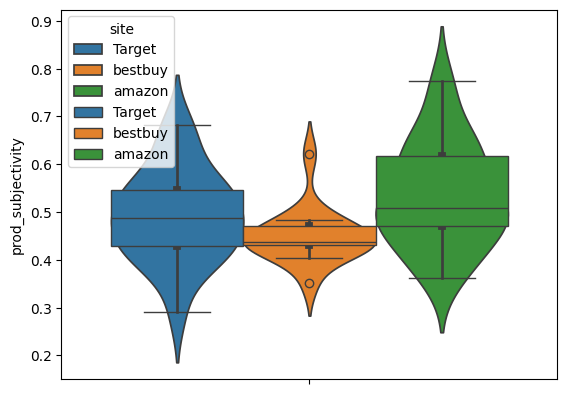

In [ ]:
import seaborn as sns

sns.violinplot(
    data=all_products,
    y='prod_subjectivity',
    hue='site'
)



<Axes: ylabel='prod_subjectivity'>

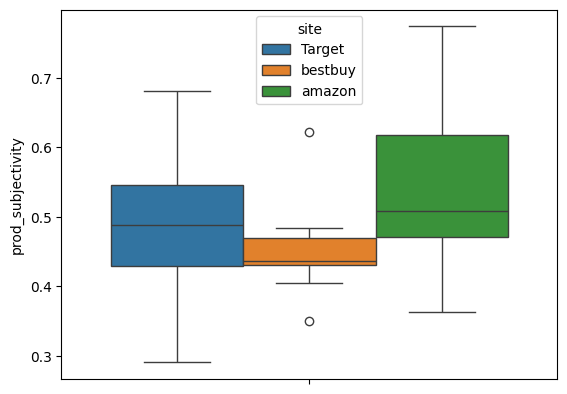

In [ ]:
sns.boxplot(
    data=all_products,y='prod_subjectivity',
    hue='site'
)

In [ ]:
print('\n'.join(list(all_reviews[(all_reviews['review_lang']!='en')&(all_reviews['global_outlier']>0)]['review_content'].astype(str))))

En perfectas condiciones, 100% el estado de la batería, muy recomendado
Todo estuvo muy bien
Llevo un día usándolo y aparecer funciona bien y en lo físico también se mira bien y las batería esta al 100% de vida
Excelente producto y llego bien embalado
Me encanto llego en muy buen estado…
La vida de batería esta al %100 quede fascinada
De regalo de cumpleaños a mi esposa.
Teléfono impecable, como nuevo, ni un rasguño, batería 100%.
Sin duda pronto compraré uno para mi.
Como nuevo ! Excelente relación precio calidad
Me agrado la presteza del envio
Tiene el 100% de la bateria y esta en excelente estado, ni un ralla, practicamente nuevo
Excelente equipo la verdad me sorprendido más de lo q esperaba batería 🔋 98% y sin marcas o rayones
Asta el momento esta bien la compra tengo un mes con el
La cámara no es igual a la de otros iPhone 14 . Es más opaco (colores distintos)y se ve más pequeña la imagen a comparación de la misma configuración en otros iPhones 14
Item to exspensive
Específicament

In [ ]:
import pandas as pd, numpy as np, seaborn as sns
#all_products.to_csv('../data/master_product_list.csv')
all_reviews = pd.read_csv('../data/combined_review_table.csv')
all_reviews.head()

C:\Users\pconn\AppData\Local\Temp\ipykernel_12808\3894873568.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  all_reviews = pd.read_csv('../data/combined_review_table.csv')


,Unnamed: 0,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en
0,0,1,Amazon1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.588232,0.258266,49.0,NaN,en,Amazon,0,0,0,0
1,1,1,Amazon1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.430909,0.447273,24.0,NaN,en,Amazon,0,0,0,0
2,2,1,Amazon1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.554959,0.394215,66.0,NaN,en,Amazon,0,0,0,0
3,3,1,Amazon1,Awesome,David Chaves Rojas,"Got my phone, 10/10. No scratches, still have ...",5,0,True,1.000000,1.000000,14.0,NaN,en,Amazon,2,2,0,0
4,4,1,Amazon1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.636364,0.424242,31.0,NaN,en,Amazon,0,0,0,0


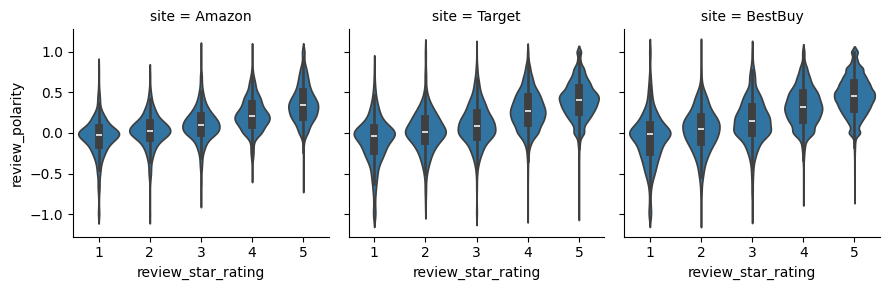

In [ ]:
g = sns.FacetGrid(
    data=all_reviews[(all_reviews['review_lang']=='en')],
    col='site'
)

g.map_dataframe(
    sns.violinplot,
    x='review_star_rating',
    y='review_polarity'
)

As star rating increases, it seems that reviews become more positive in polarity.  Generally, the median polarity is neutral on each site.

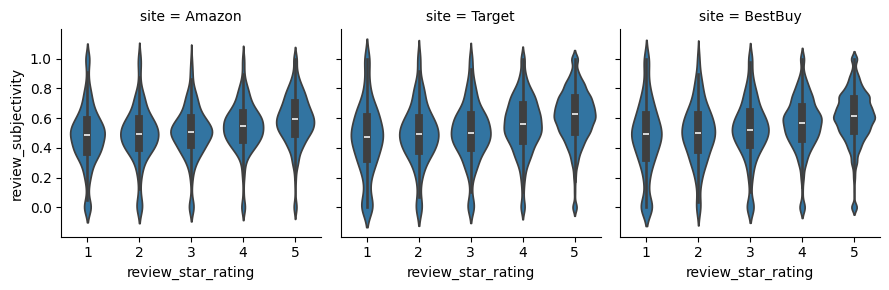

In [ ]:
g = sns.FacetGrid(
    data=all_reviews[(all_reviews['review_lang']=='en')],
    col='site'
)

g.map_dataframe(
    sns.violinplot,
    x='review_star_rating',
    y='review_subjectivity'
)

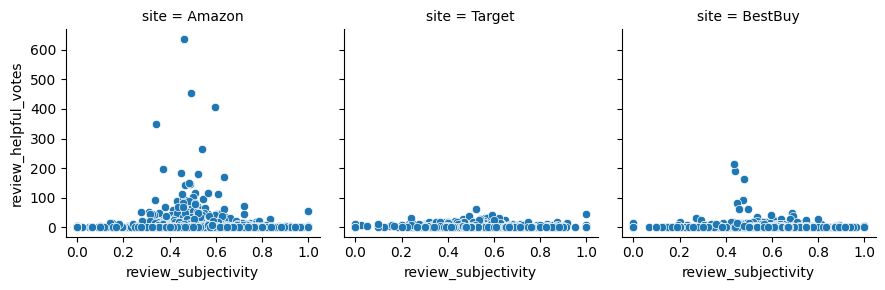

In [ ]:
g = sns.FacetGrid(
    data=all_reviews[(all_reviews['review_lang']=='en')&(all_reviews['review_helpful_votes'] > 0)],
    col='site'
)

g.map_dataframe(
    sns.scatterplot,
    x='review_subjectivity',
    y='review_helpful_votes'
)

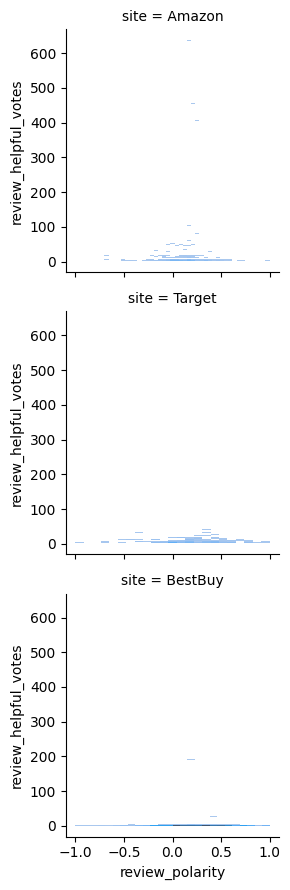

In [ ]:
g = sns.FacetGrid(
    data=all_reviews[(all_reviews['review_lang']=='en')&(all_reviews['review_helpful_votes'] > 0)],
    row='site'
)

g.map_dataframe(
    sns.histplot,
    x='review_polarity',
    y='review_helpful_votes'
)

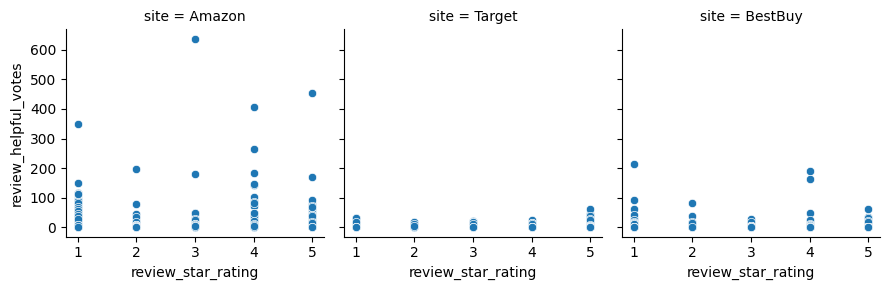

In [ ]:
g = sns.FacetGrid(
    data=all_reviews[(all_reviews['review_lang']=='en')&(all_reviews['review_helpful_votes'] > 0)],
    col='site'
)

g.map_dataframe(
    sns.scatterplot,
    x='review_star_rating',
    y='review_helpful_votes'
)

### Removing unicode characters from review_content and review_header

In [2]:
all_reviews = pd.read_csv('../data/combined_review_table.csv')
all_reviews.head()

C:\Users\uttar\AppData\Local\Temp\ipykernel_12280\1331017731.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  all_reviews = pd.read_csv('../data/combined_review_table.csv')


,Unnamed: 0,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en
0,0,1,Amazon1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.588232,0.258266,49.0,NaN,en,Amazon,0,0,0,0
1,1,1,Amazon1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.430909,0.447273,24.0,NaN,en,Amazon,0,0,0,0
2,2,1,Amazon1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.554959,0.394215,66.0,NaN,en,Amazon,0,0,0,0
3,3,1,Amazon1,Awesome,David Chaves Rojas,"Got my phone, 10/10. No scratches, still have ...",5,0,True,1.000000,1.000000,14.0,NaN,en,Amazon,2,2,0,0
4,4,1,Amazon1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.636364,0.424242,31.0,NaN,en,Amazon,0,0,0,0


In [3]:
def remove_unicode(text):
    return ''.join(char for char in text if char.isascii())

all_reviews['review_content'] = all_reviews['review_content'].astype(str)
all_reviews['review_content'] = all_reviews['review_content'].apply(remove_unicode)

all_reviews['review_header'] = all_reviews['review_header'].astype(str)
all_reviews['review_header'] = all_reviews['review_header'].apply(remove_unicode)


# test case: checking if unicode characters are removed
print(all_reviews.iloc[22])

Unnamed: 0                                                             22
productID                                                               1
prodSiteID                                                        Amazon1
review_header                                     Funciona y se mira bien
reviewer_name                                                   Daniel831
review_content          Llevo un da usndolo y aparecer funciona bien y...
review_star_rating                                                      5
review_helpful_votes                                                    0
verified_purchase                                                    True
review_subjectivity                                                   0.0
review_polarity                                                       0.0
review_length                                                        24.0
url                                                                   NaN
review_lang                           

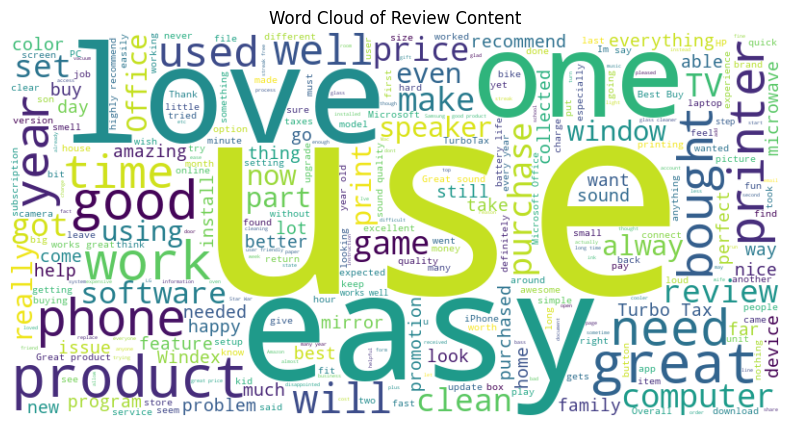

In [4]:
all_text = ' '.join(all_reviews['review_content'])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=300).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Review Content')
plt.axis('off')
plt.show()

In [5]:
all_reviews.to_csv('../data/all_reviews_without_unicode.csv')